In [1]:
# ============================================================
# 1. Setup and Library Imports
# ============================================================

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

#from google.colab import drive
#drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# ============================================================
# 2. Dataset Paths
# ============================================================

#DATA_DIR = "/content/drive/MyDrive/CS306_2025/Project2/database/dataset"
DATA_DIR = "dataset/"

classes = sorted(os.listdir(DATA_DIR))
print("Classes found:", classes)


Classes found: ['blocked', 'free', 'green', 'sheep', 'slow', 'yellow']


In [4]:
# ============================================================
# 3. Load and Preprocess Images
# ============================================================

IMG_SIZE = (64, 64)   # CNN input size
images, labels = [], []

for idx, cls in enumerate(classes):
    cls_path = os.path.join(DATA_DIR, cls)
    if not os.path.isdir(cls_path):
        continue
    for file in tqdm(os.listdir(cls_path), desc=f"Loading {cls}"):
        img_path = os.path.join(cls_path, file)
        try:
            img = imread(img_path)
            if img.ndim == 2:  # grayscale → RGB
                img = np.stack([img]*3, axis=-1)
            img_resized = resize(img, IMG_SIZE, anti_aliasing=True)
            images.append(img_resized)
            labels.append(idx)
        except:
            continue

X = np.array(images)
y = np.array(labels)

print("Image data shape:", X.shape)
print("Unique classes:", np.unique(y))


Loading yellow: 100%|██████████| 86/86 [00:33<00:00,  2.60it/s]

Image data shape: (724, 64, 64, 3)
Unique classes: [0 1 2 3 4 5]


In [5]:
# ============================================================
# 4. Split Data
# ============================================================

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Normalize pixel values
X_train, X_val, X_test = X_train/1.0, X_val/1.0, X_test/1.0

# One-hot encode labels
num_classes = len(classes)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


Train: (506, 64, 64, 3) Val: (109, 64, 64, 3) Test: (109, 64, 64, 3)


In [6]:
# ============================================================
# 5. Define CNN Model
# ============================================================

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,926 (6.20 MB)

 Trainable params: 1,625,926 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ============================================================
# 6. Train CNN
# ============================================================

start_time = time.time()

history = model.fit(X_train, y_train_cat,
                    validation_data=(X_val, y_val_cat),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

train_time = time.time() - start_time
print(f"\nTraining time: {train_time:.1f} s")


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.3099 - loss: 1.7427 - val_accuracy: 0.3486 - val_loss: 1.6313
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.3532 - loss: 1.5793 - val_accuracy: 0.5321 - val_loss: 1.4636
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.4935 - loss: 1.4121 - val_accuracy: 0.5505 - val_loss: 1.2209
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.5781 - loss: 1.1960 - val_accuracy: 0.6422 - val_loss: 1.0351
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.6896 - loss: 0.9468 - val_accuracy: 0.6789 - val_loss: 0.9077
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.7692 - loss: 0.8309 - val_accuracy: 0.7706 - val_loss: 0.8013
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.7746 - loss: 0.6818 - val_accuracy: 0.7523 - val_loss: 0.7031
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.7664 - loss: 0.6473 - val_accuracy: 0.

In [8]:
# ============================================================
# 7. Evaluate Model
# ============================================================

val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Validation Accuracy: {val_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))


Validation Accuracy: 0.908
Test Accuracy: 0.899
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Classification Report:
              precision    recall  f1-score   support

     blocked       1.00      0.85      0.92        20
        free       0.81      1.00      0.89        38
       green       1.00      1.00      1.00        11
       sheep       0.83      0.45      0.59        11
        slow       0.94      1.00      0.97        16
      yellow       1.00      0.85      0.92        13

    accuracy                           0.90       109
   macro avg       0.93      0.86      0.88       109
weighted avg       0.91      0.90      0.89       109



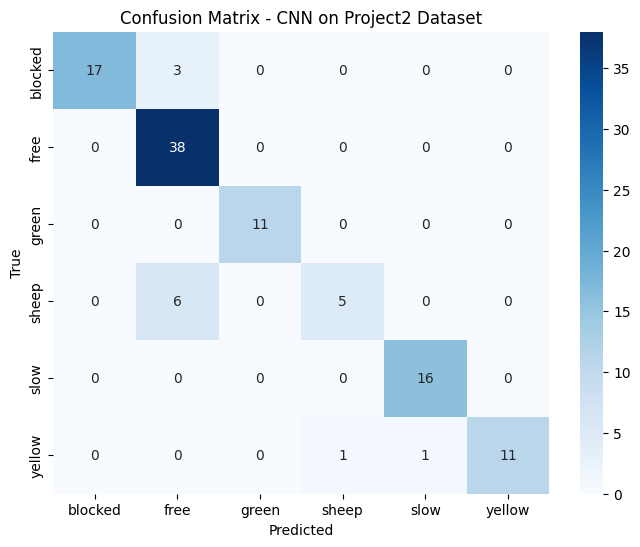

In [9]:
# ============================================================
# 8. Confusion Matrix
# ============================================================

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN on Project2 Dataset")
plt.show()


In [10]:
# ============================================================
# 9. Save Model
# ============================================================

SAVE_PATH = "/content/drive/MyDrive/CS306_2025/Project2/cnn_project2_model.keras"
model.save(SAVE_PATH)
print("Model saved to:", SAVE_PATH)


Model saved to: /content/drive/MyDrive/CS306_2025/Project2/cnn_project2_model.keras


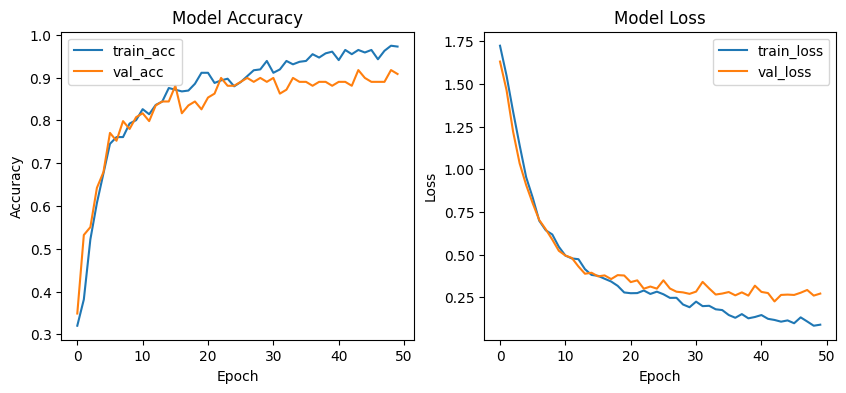

In [11]:
# ============================================================
# 10. Visualize Training History
# ============================================================

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
